<a href="https://colab.research.google.com/github/xoreo/md/blob/master/Notebooks/Basic_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Model

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

In [24]:
# These exist for convenience
class Point:
  def __init__(self, x, y):
    self.x, self.y = x, y

class Padding:
  def __init__(self, left, right):
    self.l, self.r = left, right

In [63]:
PARTICLE_MASS = 1
EDGE_LEN = 15
N_PARTICLES = 64

PADDING = Padding(
    5, # Left corner
    2, # Right corner
)

LOWER_WINDOW = -0.5
UPPER_WINDOW = EDGE_LEN + 0.5

## Some notes on how this is implemented
Right now, the n_particles parameter for the Box2D constructor might not always be accurate to the current amount of particles in a Box2D at any given point in time. This is because of the way that the amount of particles are calculated. Right now, there will always be a perfect square number of particles in the box, just to make it easier for the particles to be equally spread out. This doesn't need to always be the case, but it is good for right now.

Definitions

Pressure:

In [97]:
# Particle represents a singular particle.
class Particle:
  def __init__(
    self,
    index,
    mass=PARTICLE_MASS,
    random_vels=False,
    vels=(1, 1),
  ): 
    self.mass = mass
    self.index = index # Index in all related vectors
    # In order for acceleration to be zero, velocity must be constant.
    if random_vels:
      self.vel = Point(
        (0 + (random.random() / 1.)),
        (0 + (random.random() / 1.)),
      )
    else:
      self.vel = Point(vels[0], vels[1])

  def kinetic_energy_x(self):
    return self.mass * (self.vel.x ** 2) * 0.5

  def kinetic_energy_y(self):
    return self.mass * (self.vel.y ** 2) * 0.5

# Box2D represents a two-dimensional box of particles.
class Box2D:
  def __init__(
      self,
      n_particles=N_PARTICLES,
      edge_len=EDGE_LEN,
      padding=PADDING,
      window=(UPPER_WINDOW, LOWER_WINDOW),
      random_vels=True,
      vels=(1, 1),
  ):
    self.edge_len = edge_len
    self.perimiter = self.edge_len * 4
    self.ppr = int(np.sqrt(n_particles)) # Number of particles per row
    self.n_particles = self.ppr ** 2 # The number of particles.
    self.padding = padding
    self.window = window

    # Bad design, I know, but don't worry about these
    self.random_vels=random_vels
    self.vels=vels
    '''
    self.positions:
     x  |  y 
    ---------
    ... | ...
    ---------
    indexed by self.positions[some_particle.index] -> numpy.array([x, y])
    '''
    self.positions = np.zeros(shape=(self.ppr ** 2, 2))

    '''
    self.particles:
    indexed by self.particles[index] -> Particle
    '''
    self.particles = np.empty(self.ppr ** 2, dtype=object)
    
    '''
    self.bounces:
    indexed by self.bounces[index] -> Number of bounces of that particle in x
    and y directions
    '''
    self.bounces = np.zeros(shape=(self.n_particles, 2))
    self.temps = [] # A history of the temperature of the system
    self.pressures = [] # A history of the pressure of the system
    self.time = 0 # The current time of the system
    
    self.populate()
  
  # populate populates the Box2D with a square number of equally-spaced
  # particles.
  def populate(self):
    space = np.linspace(
        float(self.padding.r),
        self.edge_len - float(self.padding.l),
        self.ppr
    )

    for row in range(space.size):
      for col in range(space.size):
          # Calc the C-style index for the vectors
          index = self.ppr * col + row

          particle_x_pos = space[col]
          particle_y_pos = space[row]
          self.positions[index][0] = particle_x_pos 
          self.positions[index][1] = particle_y_pos
          
          self.particles[index] = Particle(
              index, 
              random_vels=self.random_vels, 
              vels=self.vels
          )

  # calc_positions calculates the positions of the particles in the box.
  def calc_positions(self, delta_t):
    # I will vectorize this later, but I want to get it working first
    for particle in self.particles:
      # Made these just for readability
      x_pos = self.positions[particle.index][0]
      y_pos = self.positions[particle.index][1]
      
      # Collision detection with the wall
      # Right wall
      if x_pos + particle.vel.x >= self.edge_len:
        self.bounces[particle.index][0] += 1
        particle.vel.x *= -1
        self.positions[particle.index][0] = self.edge_len
        
      # Left wall
      if x_pos + particle.vel.x <= 0:
        self.bounces[particle.index][0] += 1
        particle.vel.x *= -1
        self.positions[particle.index][0] = 0

      # Ceiling
      if y_pos + particle.vel.y >= self.edge_len:
        self.bounces[particle.index][1] += 1
        particle.vel.y *= -1
        self.positions[particle.index][1] = self.edge_len 
      
      # Floor
      if y_pos + particle.vel.y <= 0:
        self.bounces[particle.index][1] += 1
        particle.vel.y *= -1
        self.positions[particle.index][1] = 0

      self.positions[particle.index][0] += particle.vel.x * delta_t # x
      self.positions[particle.index][1] += particle.vel.y * delta_t # y
     
  # calc_temp calculates the temperature of the system.
  def calc_temp(self):
    kinetic_energies_x = np.zeros(self.n_particles)
    kinetic_energies_y = np.zeros(self.n_particles)
    for i in range(self.n_particles):
      kinetic_energies_x[i] = self.particles[i].kinetic_energy_x()
      kinetic_energies_y[i] = self.particles[i].kinetic_energy_y()

    # Temperature is the average kinetic energy of the system
    self.temps.append(
        np.average([
          np.average(kinetic_energies_x),
          np.average(kinetic_energies_y),
        ])
    )

  # calc_pressure calculates the pressure of the system.
  def calc_pressure(self):
    P = 0 # Pressure
    for i in range(len(self.bounces)):
      # Force of horizontal collisions
      p_y = np.abs(self.particles[i].mass * self.particles[i].vel.y)
      F_y = p_y * 2 * self.bounces[i][0]
      P += F_y

      # Force of vertical collisions
      p_x = np.abs(self.particles[i].mass * self.particles[i].vel.x)
      F_x = p_x * 2 * self.bounces[i][1]
      P += F_x

    P /= self.perimiter * self.time
    return P

  # step steps the system by one unit of time.
  def step(self):
    self.time += 1
    self.calc_positions(1)
    self.calc_temp()
    self.pressures.append(self.calc_pressure())
  
  # step_n steps n times.
  def step_n(self, n=1, show=True, silent=False):
    for i in range(n):
      self.step()
      if show and not silent:
        self.show()
      elif not show:
        print(f't = {self.time}/{n}')

  # show shows a graph of the current positions of the particles in the box.
  def show(self, notemp=False, eq_data=(-1, -1, -1)):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(25, 5))
    particles = axes[0]
    temperature = axes[1]
    pressure = axes[2]

    # -- Particles plot -- #
    particles.scatter(
      self.positions[:,0], # x
      self.positions[:,1], # y
    )
    particles.set_title(f'Particles @ t = {self.time}')

    rect = patches.Rectangle(
      (0, 0), self.edge_len, self.edge_len,
      linewidth = 1,
      edgecolor = 'b',
      facecolor = 'none'
    )

    particles.add_patch(rect)

    particles.set_xlim([self.window[1], self.window[0]])
    particles.set_ylim([self.window[1], self.window[0]])

    # -- Temperature plot -- #
    temperature.plot(
        np.linspace(0, self.time, len(self.temps)), # x axis
        self.temps, # y axis
    )
    temperature.set_title(f'Temperature @ t = {self.time}')

    # -- Pressure plot -- #
    pressure.plot(
      np.linspace(0, self.time, len(self.pressures)),
      self.pressures,
    )
    pressure.set_title(f'Pressure @ t = {self.time}')
    if eq_data != (-1, -1, -1):
      pressure.axvline(x=eq_data[0], color='r')
      pressure.axhline(y=eq_data[1], color='g')
      pressure.axhline(y=eq_data[2], color='purple')

    x_start = eq_data[0] - 100
    x_end = eq_data[0] + 100
    axes[3].plot(
      np.linspace(x_start, x_end, len(self.pressures[x_start:x_end])),
      self.pressures[x_start:x_end],
    )
    axes[3].set_title(f'Pressure @ t = {self.time} zoomed in at equilibrium')
    if eq_data != (-1, -1, -1):
      axes[3].axvline(x=eq_data[0], color='r')
      axes[3].axhline(y=eq_data[1], color='g')
      axes[3].axhline(y=eq_data[2], color='purple')
      
  # calc_relaxation_time runs the simulation and calculates the amount of time
  # it takes for the system to equilibrate.
  def calc_relaxation_time(self):
    threshold = .0150
    trials = 1000

    self.step_n(trials, silent=True)
    equilibrium = np.average(self.pressures[-500:]) # Calculate equilibrium point
    upper_limit = ((1. + threshold) * equilibrium)
    lower_limit = ((1. - threshold) * equilibrium)
    for i in range(len(self.pressures) - 1, -1, -1):
      difference = np.abs(equilibrium - self.pressures[i])
      # print(f'pressure = {self.pressures[i]}\nequilibrium = {equilibrium}\nupper = {upper_limit}\nlower = {lower_limit}\ndifference = {difference}\n')
      if self.pressures[i] > upper_limit or self.pressures[i] < lower_limit:
        return i, lower_limit, upper_limit

equilibrium = 226


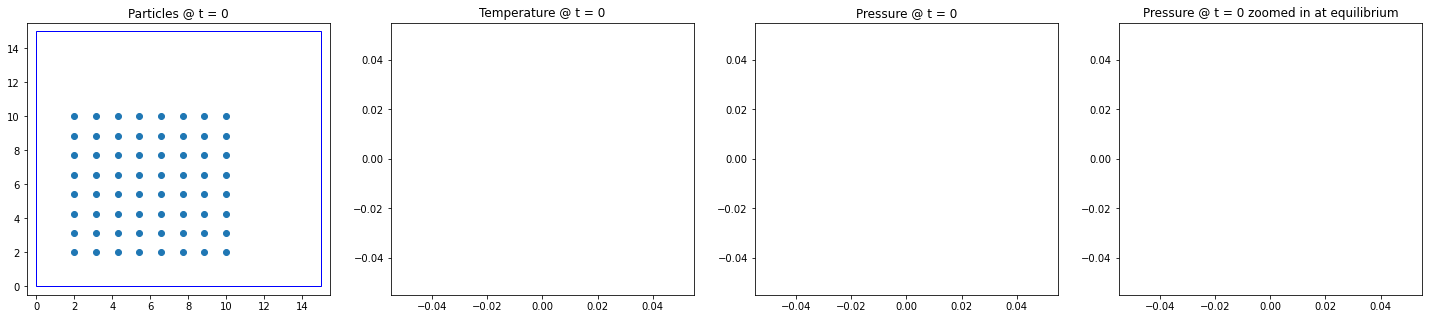

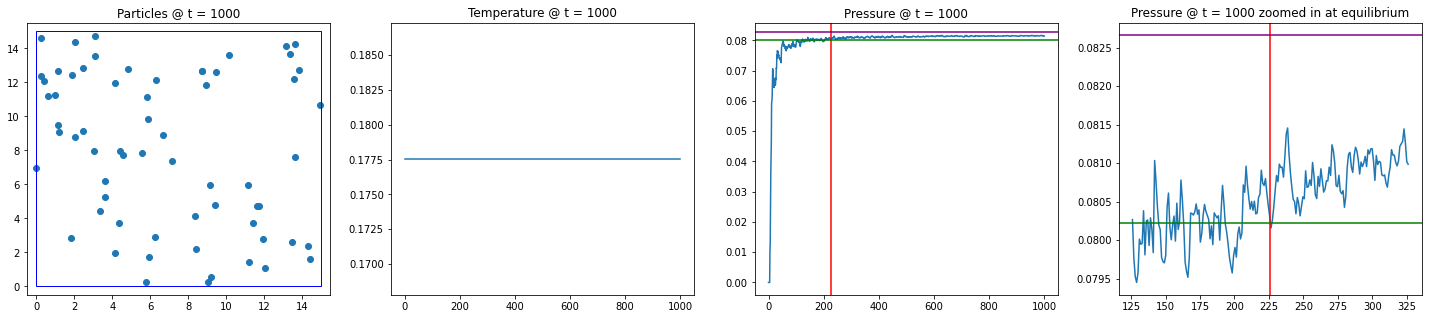

In [98]:
box = Box2D()
box.show()
equilibrium, lower, upper = box.calc_relaxation_time()
np.savetxt("/content/drive/My Drive/pressures3.csv", box.pressures, delimiter=",")
box.show(eq_data=(equilibrium, lower, upper))
print(f'equilibrium = {equilibrium}')

Now that the basic simulation is working, let's run it a bunch of times while playing with the knobs. We'll construct a handy dataset for testing relaxation time calculations.

Streaming output truncated to the last 5000 lines.
t = 2/5000
t = 3/5000
t = 4/5000
t = 5/5000
t = 6/5000
t = 7/5000
t = 8/5000
t = 9/5000
t = 10/5000
t = 11/5000
t = 12/5000
t = 13/5000
t = 14/5000
t = 15/5000
t = 16/5000
t = 17/5000
t = 18/5000
t = 19/5000
t = 20/5000
t = 21/5000
t = 22/5000
t = 23/5000
t = 24/5000
t = 25/5000
t = 26/5000
t = 27/5000
t = 28/5000
t = 29/5000
t = 30/5000
t = 31/5000
t = 32/5000
t = 33/5000
t = 34/5000
t = 35/5000
t = 36/5000
t = 37/5000
t = 38/5000
t = 39/5000
t = 40/5000
t = 41/5000
t = 42/5000
t = 43/5000
t = 44/5000
t = 45/5000
t = 46/5000
t = 47/5000
t = 48/5000
t = 49/5000
t = 50/5000
t = 51/5000
t = 52/5000
t = 53/5000
t = 54/5000
t = 55/5000
t = 56/5000
t = 57/5000
t = 58/5000
t = 59/5000
t = 60/5000
t = 61/5000
t = 62/5000
t = 63/5000
t = 64/5000
t = 65/5000
t = 66/5000
t = 67/5000
t = 68/5000
t = 69/5000
t = 70/5000
t = 71/5000
t = 72/5000
t = 73/5000
t = 74/5000
t = 75/5000
t = 76/5000
t = 77/5000
t = 78/5000
t = 79/5000
t = 80/5000
t = 81/50

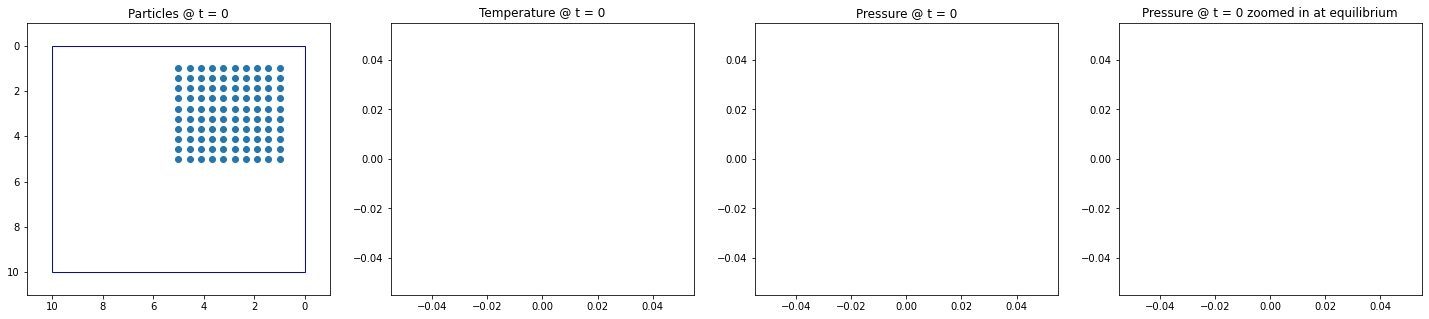

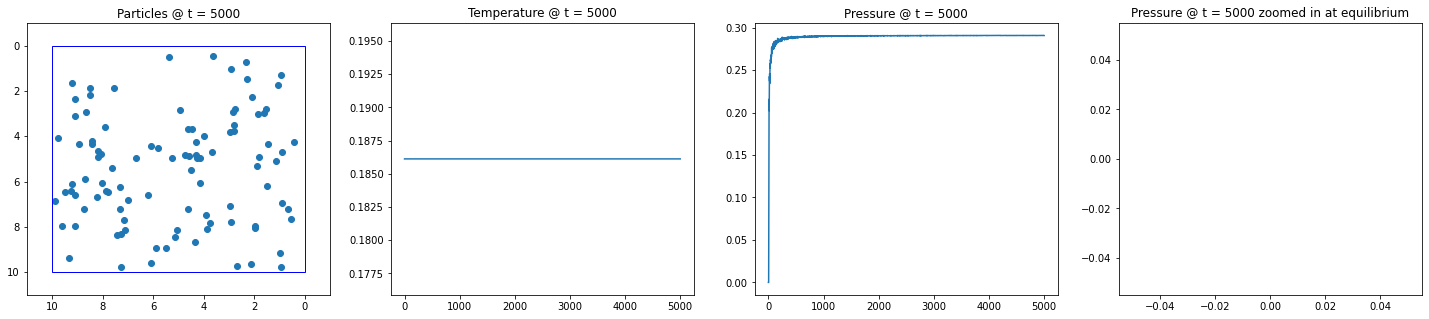

In [99]:
import os, pickle

# Get a filepath
fn = lambda s, trial : f'/content/drive/My Drive/md_data/trial_{trial}/{s}'

ITERATIONS = 5000

def run_trial(
  n_particles,
  edge_len,
  padding,
  window,
  random_vels, vels,
  trial,
):
  os.system(f'mkdir -p {fn("", trial)}')

  box = Box2D(
      n_particles=n_particles,
      edge_len=edge_len,
      padding=padding,
      random_vels=random_vels,
      vels=vels,
      window=window,
  )

  box.show()
  plt.savefig(fn('t_0.png', trial))

  box.step_n(ITERATIONS, show=False)

  box.show()
  plt.savefig(fn(f't_{box.time}.png', trial))

  with open(fn('stats.txt', trial), 'w') as fd:
    stats = [
        f'iterations = {ITERATIONS}',
        f'n_particles = {box.n_particles}',
        f'edge_len = {box.edge_len}',
        f'padding = ({box.padding.r}, {box.padding.l})',
        f'random_vels = {box.random_vels}',
        f'vels (if not random) = {box.vels}',
        f'equilibrium = {box.pressures[-1]}',
    ]
    fd.write('\n'.join(stats))
  
  with open(fn('box_dump.pickle', trial), 'wb') as fd:
    pickle.dump(box, fd)

edge_len = 10
run_trial(
    100, # Number of particles
    edge_len, # Edge length
    Padding(5, 1), # Padding
    (-1.0, edge_len + 1.0), # Window size
    True, (0, 0),
    5, # Trial number
)